In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import re

In [2]:
def extract_dataset_name(path: str) -> str:
    # Get the folder name right after "logs/"
    folder_name = os.path.basename(os.path.dirname(path))
    # Remove the trailing timestamp (matches "_YYYY-MM-DD_HH-MM-SS")
    dataset_name = re.sub(r'_\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}$', '', folder_name)
    return dataset_name

In [3]:
# Path to the CSV file
csv_path = "logs/Swiss_Roll_2025-08-15_21-15-12/prdc_all_regs_steps.csv"
dataset_name = extract_dataset_name(csv_path) # Load CSV
df = pd.read_csv(csv_path)
# Display first few rows
df.head()


,reg,step,precision,recall,density,coverage
0,0.0,0,0.0173 ± 0.0255,0.9987 ± 0.0029,0.0126 ± 0.0189,0.0606 ± 0.0802
1,0.0,1000,0.7227 ± 0.0469,0.9986 ± 0.0010,0.6008 ± 0.0598,0.8442 ± 0.0218
2,0.0,2000,0.8800 ± 0.0415,0.9980 ± 0.0011,0.8088 ± 0.0606,0.9229 ± 0.0181
3,0.0,3000,0.9425 ± 0.0179,0.9966 ± 0.0020,0.9053 ± 0.0283,0.9426 ± 0.0137
4,0.0,4000,0.9542 ± 0.0088,0.9969 ± 0.0008,0.9186 ± 0.0176,0.9467 ± 0.0140


In [4]:
# Specify the step and regs you want to show
step_value = 1000

regs_to_show = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]  # list the reg values you want
# regs_to_show = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

summary = df[df['step'] == step_value]
summary = summary[summary['reg'].isin(regs_to_show)]
summary = summary.drop(columns=['step']).reset_index(drop=True)

# Split ± columns into mean and std
for col in ['precision', 'recall', 'density', 'coverage']:
    summary[[f'{col}_mean', f'{col}_std']] = summary[col].str.split(' ± ', expand=True)
    summary[f'{col}_mean'] = summary[f'{col}_mean'].astype(float)
    summary[f'{col}_std'] = summary[f'{col}_std'].astype(float)

# Keep reg + mean columns for coloring
highlight_cols = ['precision_mean', 'recall_mean', 'density_mean', 'coverage_mean']
display_cols = ['reg'] + highlight_cols

# Display with gradient on mean values
summary[display_cols].style.background_gradient(subset=highlight_cols, cmap='Greys')


,reg,precision_mean,recall_mean,density_mean,coverage_mean
0,0.000000,0.722700,0.998600,0.600800,0.844200
1,0.100000,0.749900,0.998100,0.631600,0.849900
2,0.200000,0.778000,0.995000,0.667100,0.858900
3,0.300000,0.764700,0.994200,0.649500,0.847200
4,0.400000,0.687800,0.994200,0.560300,0.808300
5,0.500000,0.676400,0.997200,0.546300,0.824600


In [5]:
regs_to_plot = [0, 0.3]  # change as needed

# Filter dataframe for selected regs
plot_df = df[df['reg'].isin(regs_to_plot)].copy()

metrics = ['precision', 'recall', 'density', 'coverage']


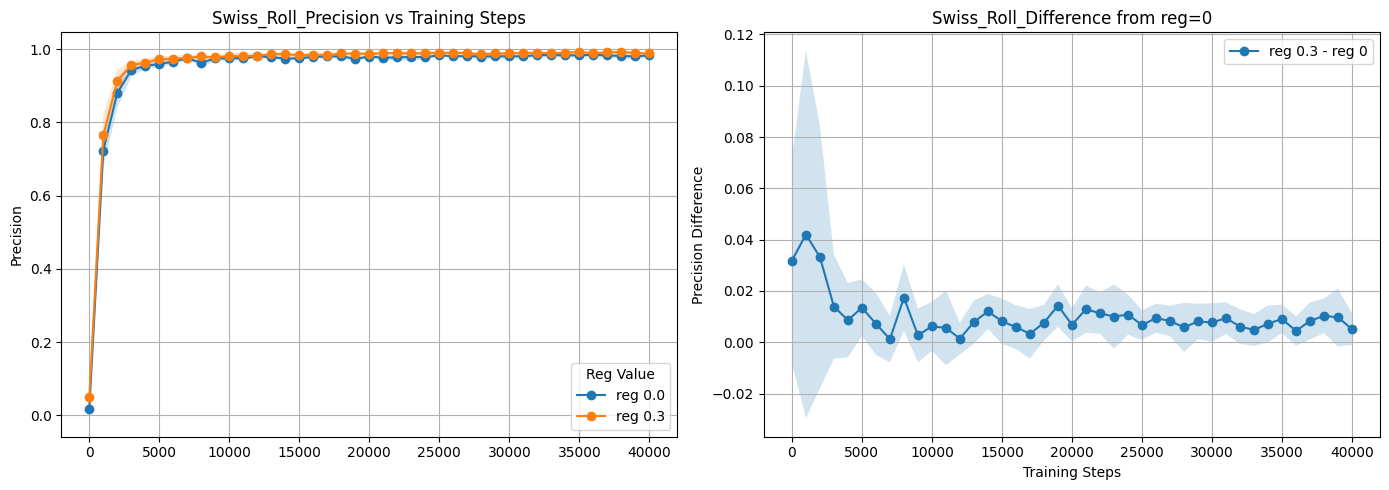

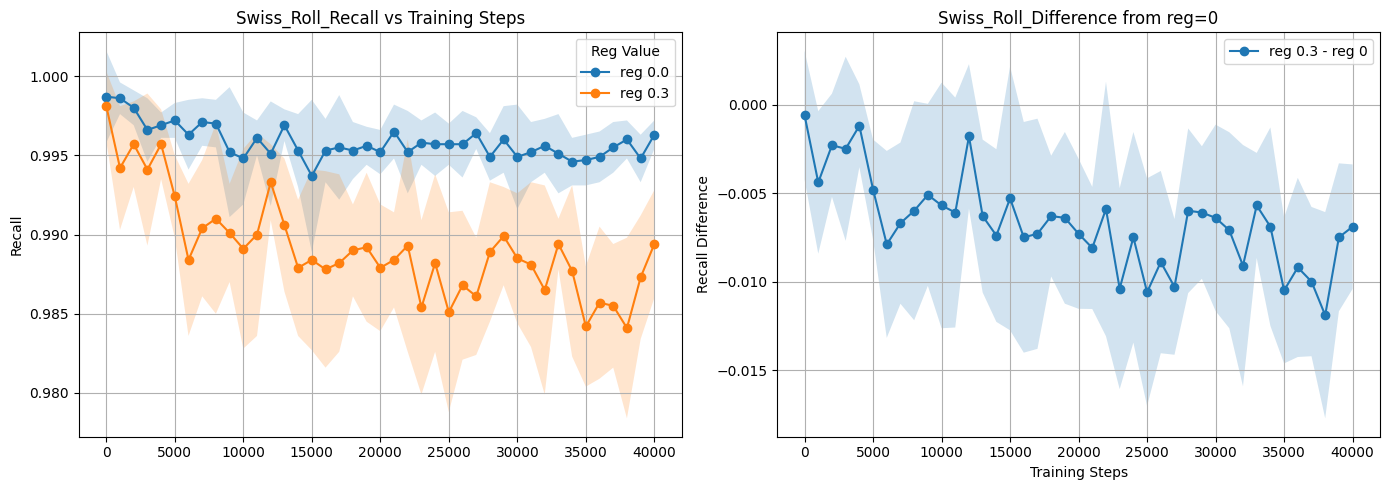

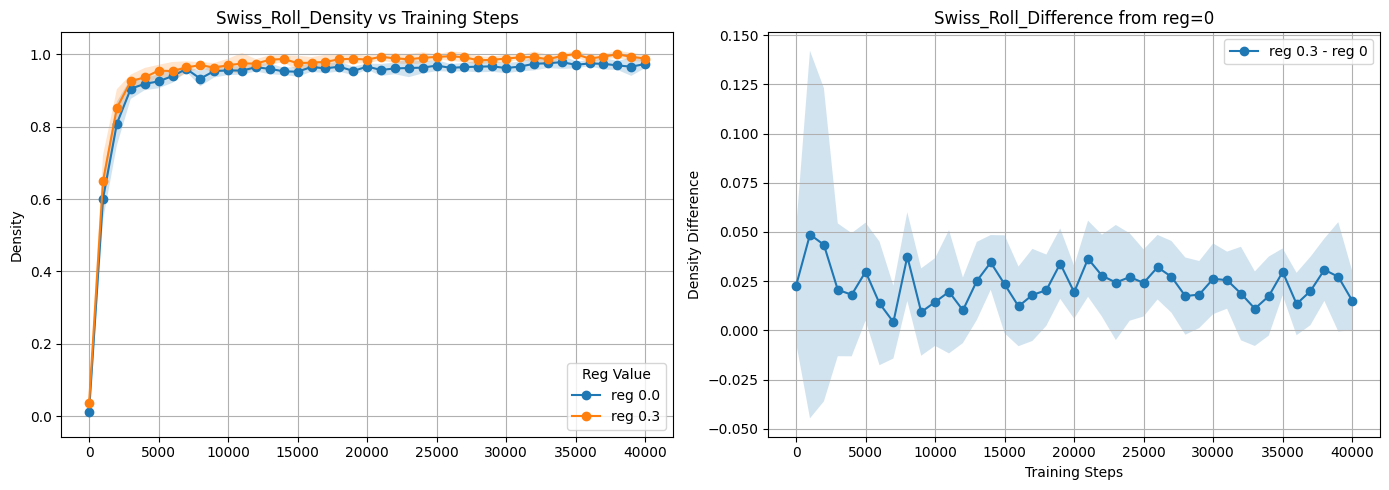

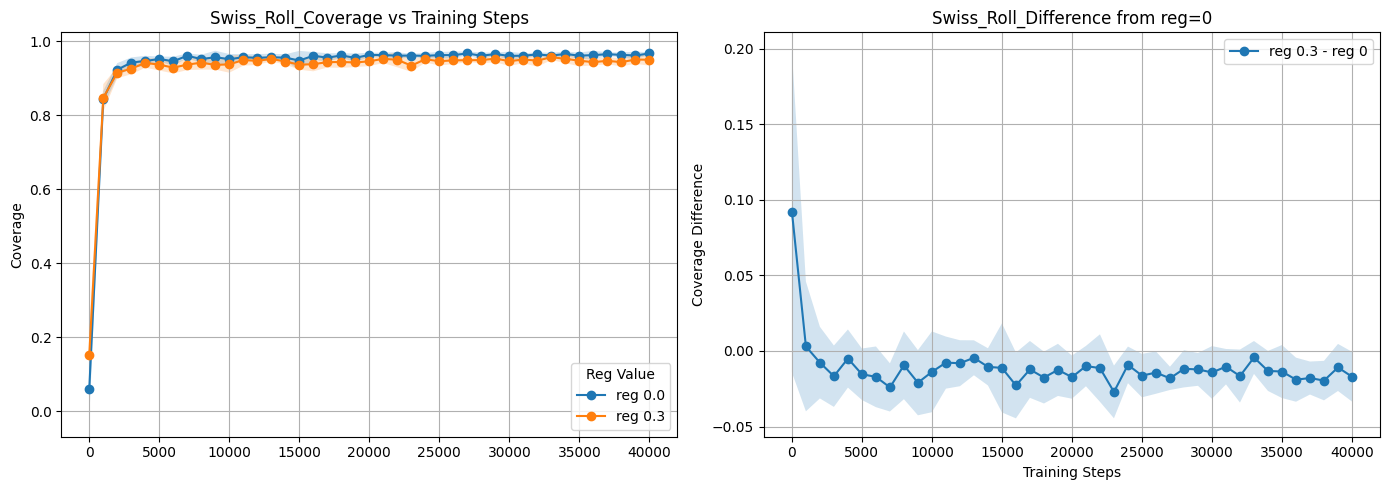

In [6]:
# Split ± std into numeric columns for all metrics
for metric in metrics:
    plot_df[[f'{metric}_mean', f'{metric}_std']] = plot_df[metric].str.split(' ± ', expand=True)
    plot_df[f'{metric}_mean'] = plot_df[f'{metric}_mean'].astype(float)
    plot_df[f'{metric}_std'] = plot_df[f'{metric}_std'].astype(float)

# Plot each metric
for metric in metrics:
    baseline = plot_df[plot_df['reg'] == 0]
    others = plot_df[plot_df['reg'] != 0]

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    # Left: original metric curves with ± std shading
    for reg_val in plot_df['reg'].unique():
        reg_data = plot_df[plot_df['reg'] == reg_val]
        axs[0].plot(reg_data['step'], reg_data[f'{metric}_mean'], marker='o', label=f'reg {reg_val}')
        axs[0].fill_between(reg_data['step'], 
                            reg_data[f'{metric}_mean'] - reg_data[f'{metric}_std'], 
                            reg_data[f'{metric}_mean'] + reg_data[f'{metric}_std'], 
                            alpha=0.2)
    axs[0].set_ylabel(metric.capitalize())
    axs[0].set_title(f'{dataset_name}_{metric.capitalize()} vs Training Steps')
    axs[0].grid(True)
    axs[0].legend(title='Reg Value')

    # Right: difference from baseline (reg=0) with ± std propagation
    for reg_val in others['reg'].unique():
        reg_data = others[others['reg'] == reg_val]
        diff = reg_data[f'{metric}_mean'].values - baseline[f'{metric}_mean'].values
        diff_std = np.sqrt(reg_data[f'{metric}_std'].values**2 + baseline[f'{metric}_std'].values**2)
        axs[1].plot(reg_data['step'], diff, marker='o', label=f'reg {reg_val} - reg 0')
        axs[1].fill_between(reg_data['step'], diff - diff_std, diff + diff_std, alpha=0.2)
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel(f'{metric.capitalize()} Difference')
    axs[1].set_title(f'{dataset_name}_Difference from reg=0')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()
